# Trade-off between Geometric Transformation and Robustness

First sketch, a quick test

## 1 Install all the libraries

In [1]:
# INSTALL LIBRARY FOR G-CNNS
! pip install numpy scipy matplotlib nose
! pip install chainer
! pip install ipywidgets
%cd /notebooks/
! git clone https://github.com/adambielski/GrouPy.git
%cd /notebooks/GrouPy

! ls
! python3 "/notebooks/GrouPy/setup.py" install

! ls
! ls

! pip install kornia
! pip install torchattacks

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 154 kB 21.3 MB/s eta 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 1.0 MB 26.1 MB/s eta 0:00:01
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967740 sha256=9f7d37d776c9378fa464b6f6e455901c39e42839265f74ce2a20bf5421491f38
  Stored in directory: /tmp/pip-ephem-wheel-cache-hqkrejn0/wheels/c5/01/d5/3ef194fa83dbf1d97bab826ca2bf235071f412861189a7b9df
Successfully built chainer
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
/notebooks
fatal: destination path 'GrouPy' already exists and is not an empty directory.
/notebooks/GrouPy
LICENSE    calibration_library	p4_fmaps.png		 requirements.txt
README.md  groupy		p4m_fmaps.png		 setup.py
build	   p4_anim.gif		reliability_diagram.png
running install
running build
running build_py
running install_lib
creating 

In [2]:
import torch
import numpy as np
import sklearn
import scipy
import pandas as pd
import torch
import matplotlib.pyplot as plt

import torchvision
from typing import *
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

from torch.nn import functional as F
from torch.nn import Conv2d
from torch.nn import MaxPool2d as MaxPool2d
from tqdm import tqdm
import torchvision.models as models
import torchvision.datasets as datasets 
import torchvision.transforms as transforms


#import the library dedicated to Groups
from groupy.gconv.pytorch_gconv.pooling import plane_group_spatial_max_pooling
from groupy.gconv.pytorch_gconv import P4ConvZ2, P4ConvP4

## 2 Reproducability Stuff

In [3]:
#REPRODUCIABILYT STUFF

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

import random
import numpy as np
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

torch.cuda.manual_seed(0)

from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 5000})

Using device: cuda:0


## 3 Datasets

Download the datasets. **CIFAR10** and **CIFAR100**

In [4]:
from torchvision.transforms.transforms import RandomGrayscale
from torch.utils.data import random_split
from ipywidgets import IntProgress

# basic transformation trainign set 
image_transforms = transforms.Compose(
    [
        #transforms.RandomRotation(degrees=(-180,180)), 
        #ransforms.RandomGrayscale(),
        transforms.RandomHorizontalFlip(),    
        transforms.ToTensor(),
     
    ]
)

image_transforms2 = transforms.Compose(
    [
        #transforms.RandomRotation(degrees=(-30,30)), 
        transforms.RandomHorizontalFlip(),    
        transforms.ToTensor(),
    ]
)


#dataset CIFAR10
dataset_cifar10 = datasets.CIFAR10("/content/data_cifar10", train=True, download=True, transform=image_transforms)
test_set_cifar10 = datasets.CIFAR10("/content/data_cifar10", train=False, download=True, transform = image_transforms2)

#create validation validation set 
train_set_cifar10, val_set_cifar10 = random_split(dataset_cifar10, [45000, 5000])


# build the dataloaders CIFAR10
train_loader_cifar10 = torch.utils.data.DataLoader( train_set_cifar10, batch_size=64, shuffle=True, num_workers=60)
val_loader_cifar10 = torch.utils.data.DataLoader( val_set_cifar10, batch_size=64, shuffle=True, num_workers=10, pin_memory=True )
test_loader_cifar10 = torch.utils.data.DataLoader( test_set_cifar10, batch_size=64, shuffle=True, num_workers=10 )

##########################################################################################


#dataset CIFAR100
dataset_cifar100 = datasets.CIFAR100("/content/data_cifar100", train=True, download=True, transform=image_transforms)
test_set_cifar100 = datasets.CIFAR100("/content/data_cifar100", train=False, download=True, transform=image_transforms2)


#create validation validation set 
train_set_cifar100, val_set_cifar100 = random_split(dataset_cifar100, [45000, 5000])


# build the dataloader for training set CIFAR100
train_loader_cifar100 = torch.utils.data.DataLoader( train_set_cifar100, batch_size=64, shuffle=True, num_workers=20, pin_memory=True)
val_loader_cifar100 = torch.utils.data.DataLoader( val_set_cifar100, batch_size=32, shuffle=True, num_workers=10, pin_memory=True )
test_loader_cifar100 = torch.utils.data.DataLoader( test_set_cifar100, batch_size=32, shuffle=True, num_workers=10 )

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/data_cifar10/cifar-10-python.tar.gz to /content/data_cifar10
Files already downloaded and verified


/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 60 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /content/data_cifar100/cifar-100-python.tar.gz to /content/data_cifar100
Files already downloaded and verified


/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


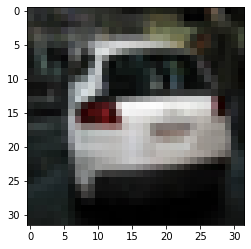

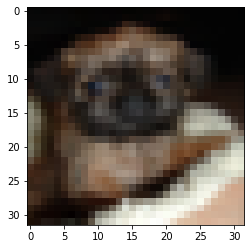

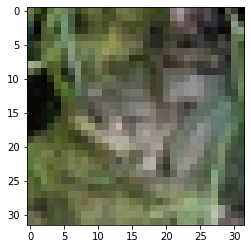

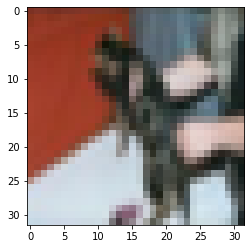

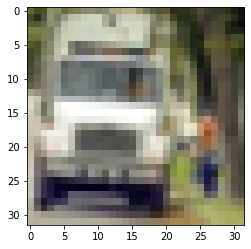

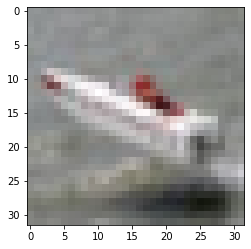

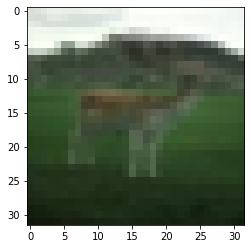

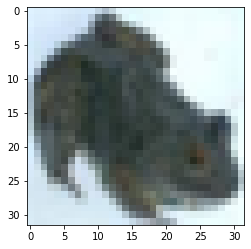

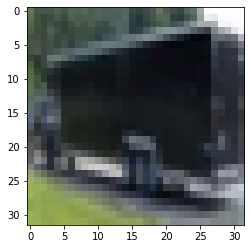

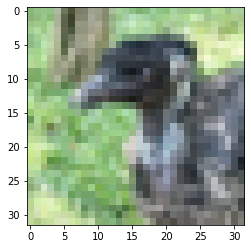

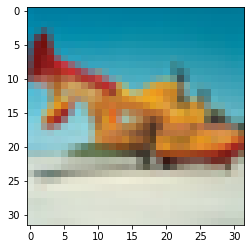

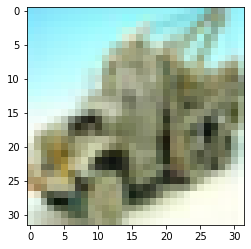

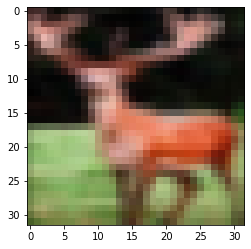

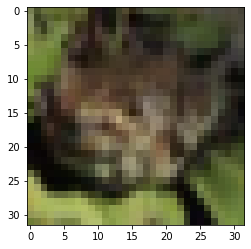

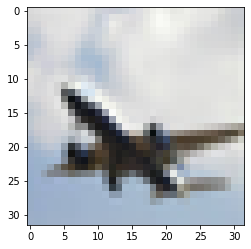

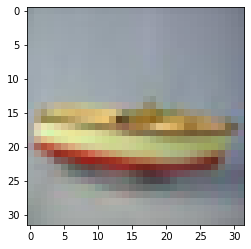

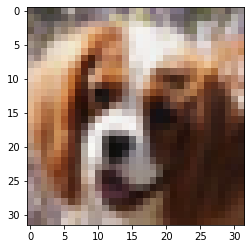

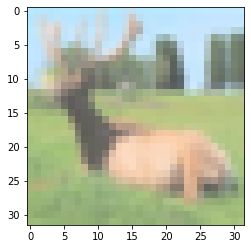

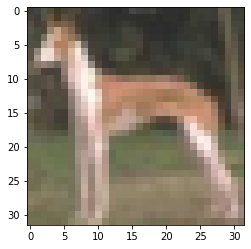

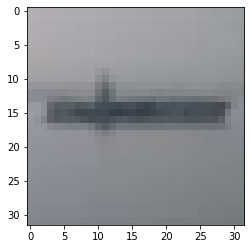

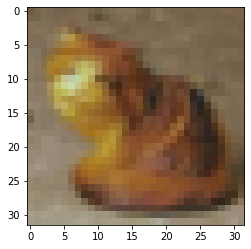

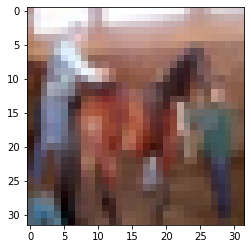

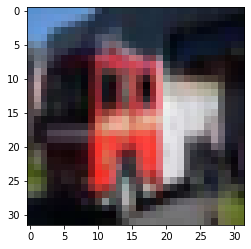

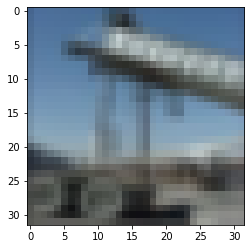

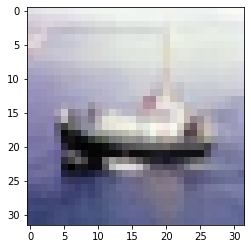

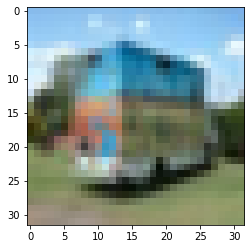

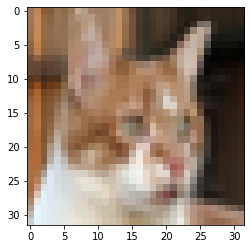

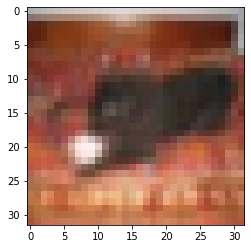

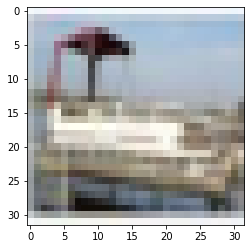

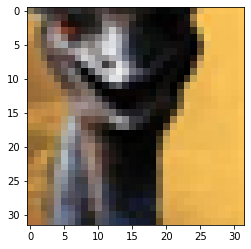

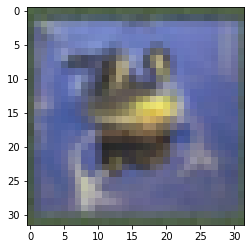

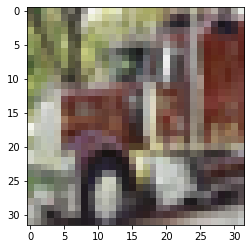

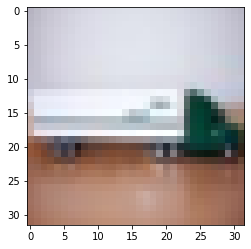

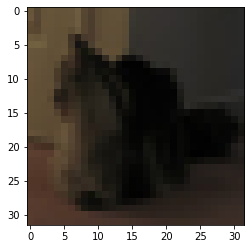

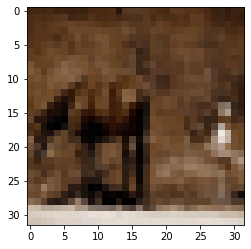

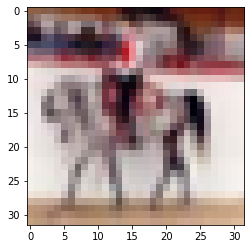

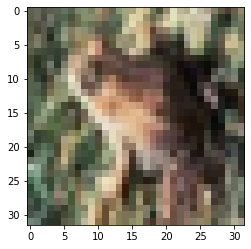

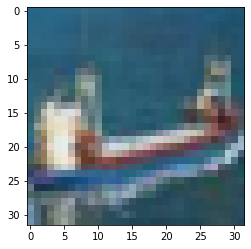

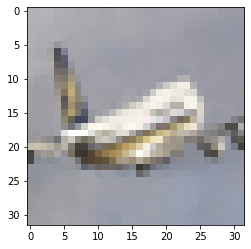

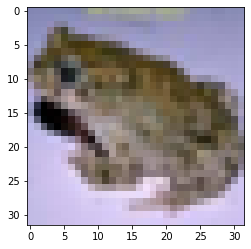

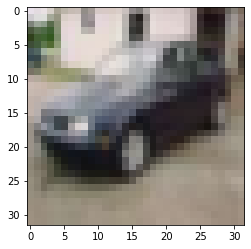

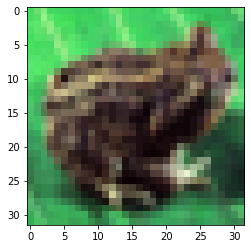

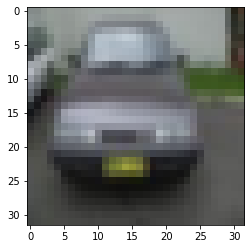

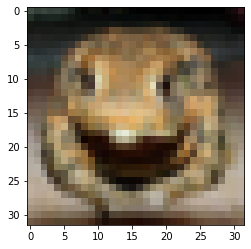

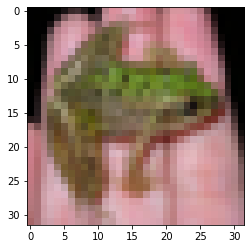

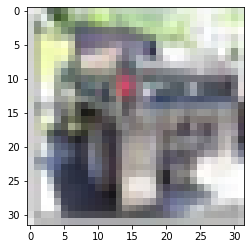

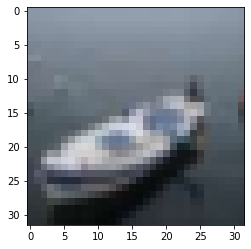

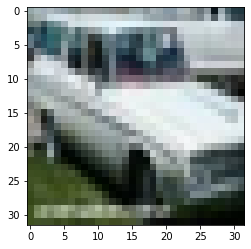

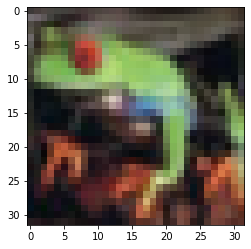

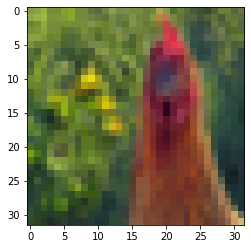

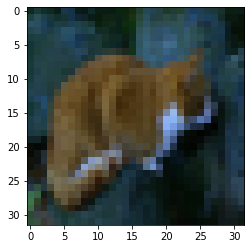

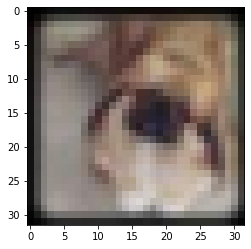

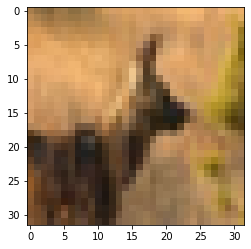

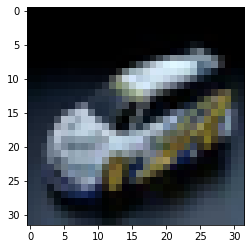

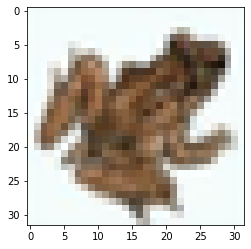

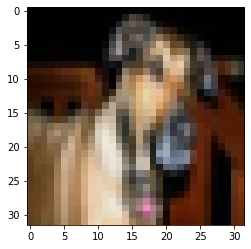

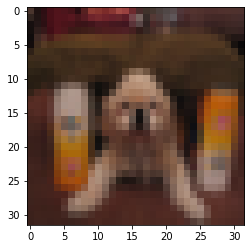

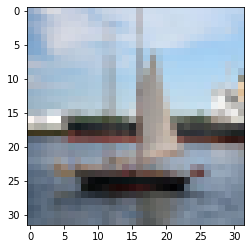

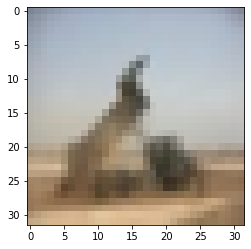

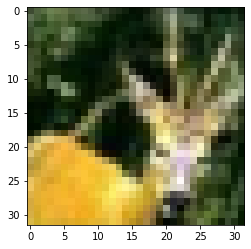

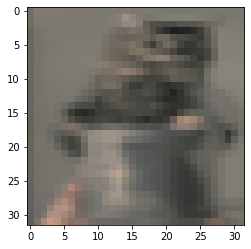

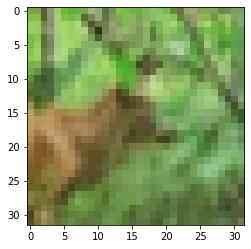

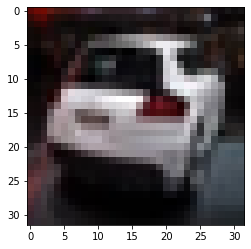

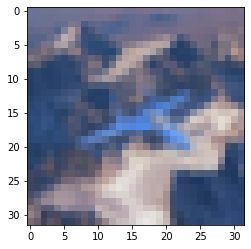

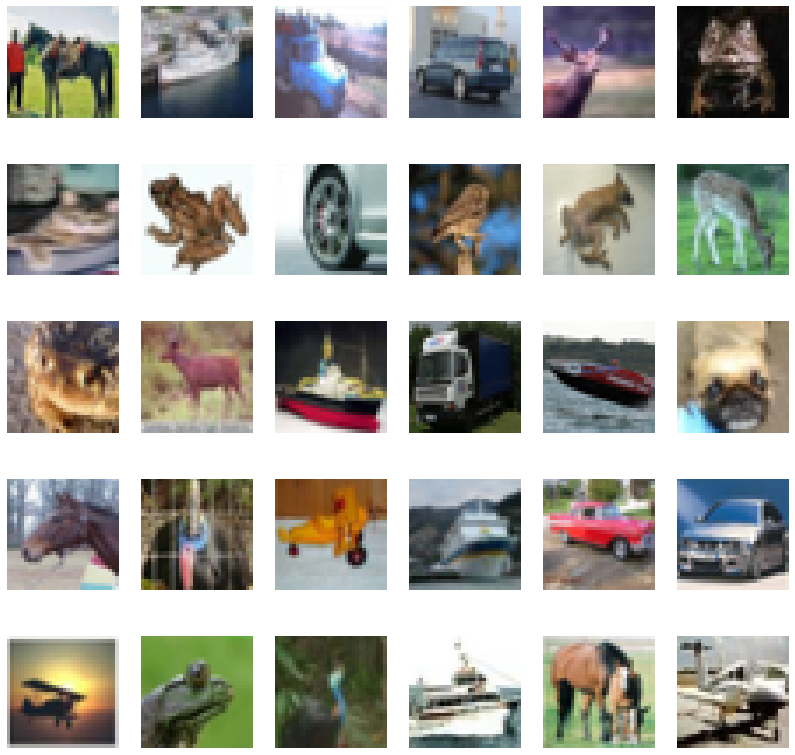

In [6]:
batch = next(iter(train_loader_cifar10))[0]


fig = plt.figure(figsize=(14, 14))
columns = 6
rows = 5

j=0
for i in range(1, columns*rows +1):
    img = batch[j]
    img = img.permute(1, 2, 0)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    j+=1
    if j==30:
        break
plt.show()
    

## 4 Models 

In [20]:
class Normalize(nn.Module):
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [21]:
"""ResNet in PyTorch.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import time

from torch.autograd import Variable


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, use_batchnorm=True):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if not use_batchnorm:
            self.bn1 = self.bn2 = nn.Sequential()

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion * planes) if use_batchnorm else nn.Sequential(),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, use_batchnorm=True):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        if not use_batchnorm:
            self.bn1 = self.bn2 = self.bn3 = nn.Sequential()

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion * planes) if use_batchnorm else nn.Sequential(),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, 
                 use_batchnorm=True):
        super(ResNet, self).__init__()

        self.in_planes = 64
        self.use_batchnorm = use_batchnorm
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64) if use_batchnorm else nn.Sequential()
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)
   
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.use_batchnorm))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out


def ResNet10(num_classes=10, use_batchnorm=True):
    return ResNet(BasicBlock, [1, 1, 1, 1], num_classes=num_classes, use_batchnorm=use_batchnorm)

def ResNet18(num_classes=10, use_batchnorm=True):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, use_batchnorm=use_batchnorm)

def ResNet34(num_classes=10, use_batchnorm=True):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, use_batchnorm=use_batchnorm)

def ResNet50(num_classes=10, use_batchnorm=True):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, use_batchnorm=use_batchnorm)

def ResNet101(num_classes=10, use_batchnorm=True):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, use_batchnorm=use_batchnorm)

def ResNet152(num_classes=10, use_batchnorm=True):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes=num_classes, use_batchnorm=use_batchnorm)

#utility function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def test():
    net = ResNet10(100,True)
    print("number of parameters : ", count_parameters(net))
    y = net(Variable(torch.randn(1, 3, 32, 32)))
    print(y.size())


test()

number of parameters :  4949412
torch.Size([1, 100])


In [22]:
'''ResNet with Group-Convolution in PyTorch.'''


from torch.autograd import Variable
from groupy.gconv.pytorch_gconv import P4MConvZ2, P4MConvP4M
from torch.nn import functional as F


# Costruisco i blocchi per Resnet come prima solo che al loro interno invece dei layer di convoluzione standard utilizzo la Group-Convolution (P4MConvZ2, P4MConvP4M)
class BasicBlock_Group(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock_Group, self).__init__()
        self.conv1 = P4MConvP4M(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = P4MConvP4M(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                P4MConvP4M(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class Bottleneck_Group(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck_Group, self).__init__()
        self.conv1 = P4MConvP4M(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = P4MConvP4M(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = P4MConvP4M(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                P4MConvP4M(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class P4mResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(P4mResNet, self).__init__()

        self.in_planes = 23

        self.conv1 = P4MConvZ2(3, 23, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(23)
        self.layer1 = self._make_layer(block, 23, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 45, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 91, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 181, num_blocks[3], stride=2)
        self.linear = nn.Linear(181*8 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        #print(x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        outs = out.size()
        out = out.view(outs[0], outs[1]*outs[2], outs[3], outs[4])
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        #print(out.shape)
        return out

def P4mResNet10(num_class):
    return P4mResNet(BasicBlock_Group, [1,1,1,1], num_classes=num_class)

def P4mResNet18(num_class):
    return P4mResNet(BasicBlock_Group, [2,2,2,2], num_classes=num_class)

def P4mResNet34():
    return P4mResNet(BasicBlock_Group, [3,4,6,3])

def P4mResNet50():
    return P4mResNet(Bottleneck_Group, [3,4,6,3])

def P4mResNet101():
    return P4mResNet(Bottleneck_Group, [3,4,23,3])

def P4mResNet152():
    return P4mResNet(Bottleneck_Group, [3,8,36,3])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def test():
    net = P4mResNet10(10)
    print("params : " , count_parameters(net))
    y = net(Variable(torch.randn(1,3,32,32)))
    print(y.size())

test()

params :  4922231
torch.Size([1, 10])


In [23]:
import kornia

## 5 Standard training, val and testing functions (clean data)

In [24]:
from tqdm import tqdm


best_acc = 0  # best test accuracy


# Clean Training
def train(epoch, loader , net, optimizer, loss_func, log_freq):

    net.train()
    running_loss=0
    correct = 0
    total = 0
    losses = []

    for batch_idx, (inputs, targets) in enumerate(tqdm(loader)):
        
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = loss_func(outputs, targets)

        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()
        
        # print statistics every log_freq mini batch
        if (batch_idx+1) % log_freq == 0:    # print every log_freq mini batches
            print('[Epoch : %d, Iter: %5d] loss: %.3f' %
                  (epoch + 1, batch_idx, running_loss / log_freq))
            losses.append( running_loss / log_freq)
            running_loss = 0.0
            print('Top1 Accuracy of the network on the trainset images:', correct / total)
            correct=0
            total=0
        
    return losses



# validation clean images
def validation(i, net, loader, loss_func, url_name_model):

    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    correct3 = 0
    correct5 = 0
    total = 0
    folder_save = url_name_model

    with torch.no_grad():

        for batch_idx, (inputs, targets) in enumerate(tqdm(loader)):
            
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = net(inputs)
            loss = loss_func(outputs, targets)

            test_loss += loss.item()

            #top1 accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum().item()

            #top3 accuracy
            targets_resize = targets.view(-1,1)
            _, predicted3 = outputs.topk(3, 1, True, True)
            correct3 += torch.eq(predicted3, targets_resize).sum().float().item()
                
            #top5 accuracy
            _, predicted5 = outputs.topk(5, 1, True, True)
            correct5 += torch.eq(predicted5, targets_resize).sum().float().item()
        
        print('Top1 accuracy of the network on the normal validation set:', 100.*correct / total)
        print('Top3 accuracy of the network on the normal validation set:', 100.*correct3 / total)
        print('Top5 accuracy of the network on the normal validation set:', 100.*correct5 / total)

        # Save checkpoint.
        
        acc = 100.*correct/total
        if acc > best_acc:
            print('Saving..')
            torch.save({
                'epoch': i,
                'model_state_dict': net.state_dict(),
                }, folder_save)
            best_acc = acc
        

# testing clean images
def testing(net, loader):
    
    net.eval()
    correct = 0
    correct3 = 0
    correct5 = 0
    total = 0

    with torch.no_grad():

        for batch_idx, (inputs, targets) in enumerate(tqdm(loader)):
            
            inputs, targets = inputs.to(device), targets.to(device)
            #inputs, targets = Variable(inputs, volatile=True), Variable(targets)
            
            outputs = net(inputs)

            #top1 accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum().item()

            #top3 accuracy
            targets_resize = targets.view(-1,1)
            _, predicted3 = outputs.topk(3, 1, True, True)
            correct3 += torch.eq(predicted3, targets_resize).sum().float().item()
                
            #top5 accuracy
            _, predicted5 = outputs.topk(5, 1, True, True)
            correct5 += torch.eq(predicted5, targets_resize).sum().float().item()

                
        print('Top1 accuracy of the network on the normal test set:', 100.*correct / total)
        print('Top3 accuracy of the network on the normal test set:', 100.*correct3 / total)
        print('Top5 accuracy of the network on the normal test set:', 100.*correct5 / total)


def adversarial_training_pgd(epoch, loader , net, optimizer, loss_func, log_freq, epsilon, steps, step_size):

    net.train()
    running_loss=0
    correct = 0
    total = 0
    losses = []

    for batch_idx, (inputs, targets) in enumerate(tqdm(loader)):
        
        inputs, targets = inputs.to(device), targets.to(device)
        atk = torchattacks.PGD(net, eps=epsilon, alpha=step_size, steps=steps)
        adv_images = atk(inputs, targets)
        

        optimizer.zero_grad()

        outputs = net(adv_images)

        loss = loss_func(outputs, targets)

        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()
        
        # print statistics every log_freq mini batch
        if (batch_idx+1) % log_freq == 0:    # print every log_freq mini batches
            print('[Epoch : %d, Iter: %5d] loss: %.3f' %
                  (epoch + 1, batch_idx, running_loss / log_freq))
            losses.append( running_loss / log_freq)
            running_loss = 0.0
            print('Top1 Adversarial Accuracy on Training set %s with PGD attack with eps= %s, num_steps=%s, step_size=%s' % (correct / total, epsilon, steps, step_size) )
            correct=0
            total=0
        
    return losses


# IT NEED NORMAL DATA, NO ROTATION FROM TORCH TRANSFORMS 
def test_spatial_rotation_robustness(model, loader, rotation_grades, printt = True): 
    
    correct = 0
    test_loss_adv = 0
    correct_adv = 0
    loss_func = nn.CrossEntropyLoss()
    
    seq = nn.Sequential(kornia.augmentation.RandomRotation(degrees=rotation_grades, p=1))
                       
    
    for data, target in loader:
    
        data_rotated = seq(data)
        data_rotated, target = data_rotated.to(device), target.to(device)
        
        '''
        data, target = data.to(device), target.to(device)
        
        # print clean accuracy
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        correct += predicted.eq(target.data).cpu().sum().item()

        '''
        # print adversarial accuracy
        data_adv = data_rotated
        output_adv = model(data_adv)
        _, predicted = torch.max(output_adv.data, 1)
        correct_adv += predicted.eq(target.data).cpu().sum().item()

    if printt == True : 
        #print(' Clean Accuracy on Non-rotated data: {}/{} ({:.0f}%)\n'.format(
        #        correct, len(loader.dataset),
        #        100. * correct / len(loader.dataset)))

        print('Accuracy on rotated data: {}/{} ({:.0f}%)\n'.format(
                 correct_adv, len(loader.dataset),
                100. * correct_adv / len(loader.dataset)))
    else:
        return 100. * correct_adv / len(loader.dataset)
    
    


# 6 Functions for Testing Raw Pixel-wise Robustness

In [25]:
import torchattacks


def test_robustness_pgd(model, loader, epsilon, alpha, steps, printt=True):

        """
            test robustness with PGD 
        """
        
        atk = torchattacks.PGD(model, eps=epsilon, alpha=alpha, steps=steps)
        #adv_images = atk(images, labels)
        
        correct = 0
        test_loss_adv = 0
        correct_adv = 0
        loss_func = nn.CrossEntropyLoss()
        
        for data, target in loader:
            
            data, target = data.to(device), target.to(device)

            # print clean accuracy
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            correct += predicted.eq(target.data).cpu().sum().item()


            # print adversarial accuracy
            data_adv = atk(data, target)
            output_adv = model(data_adv)
            _, predicted = torch.max(output_adv.data, 1)
            correct_adv += predicted.eq(target.data).cpu().sum().item()

        if printt == True:
            print('Clean Accuracy: {}/{} ({:.0f}%)\n'.format(
                correct, len(loader.dataset),
                100. * correct / len(loader.dataset)))

            print('Adv Accuracy: {}/{} ({:.0f}%)\n'.format(
                 correct_adv, len(loader.dataset),
                100. * correct_adv / len(loader.dataset)))
        else: 
            return 100. * correct_adv / len(loader.dataset)



## 7 Actaul Standard Training

In [26]:
#model
norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR, LinearLR, MultiStepLR

#add the norm layer due to torch attacks
net1 = nn.Sequential(
    norm_layer,
    ResNet10(10,True)
).to(device)


net1 = net1.eval()
print(count_parameters(net1))

#hyper-params
epsilon = 8/255
steps = 5
step_size = 2/255

epochs = 60
learning_rate = 0.001
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net1.parameters(), lr=learning_rate, weight_decay=5e-4)
loss_value = []


if torch.cuda.is_available():
    net1.cuda()

scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.10)



for i in range(epochs):
    #loss_avg = train(epoch=i, loader=train_loader_cifar10, net=net1, optimizer=optimizer, loss_func=loss_func, log_freq=250)
    loss_avg = adversarial_training_pgd(epoch=i, loader=train_loader_cifar10, net=net1, optimizer=optimizer, loss_func=loss_func, log_freq=200, epsilon=epsilon, steps = steps, step_size = step_size)
    validation(i, net1, val_loader_cifar10, loss_func, "/notebooks/models/ResNet10_cifar10_standard_training_NOdataAug_MultiStepLR_AdTrainingPGD5_8-255.pt" )
    scheduler.step()
    loss_value.append(loss_avg)


#plot training loss
y_ax = np.reshape(loss_value, (-1))
x = range(len(y_ax))
plt.plot(x,  y_ax)


In [36]:
model1 = nn.Sequential(
    norm_layer,
    ResNet10(10,True)
).to(device)

#GPU
#device = torch.device("cuda")
#ResNet10_trades.to(device)

# Test Base Model
learning_rate = 0.001
checkpoint = torch.load("/notebooks/models/ResNet10_cifar10_adv_training_dataAug180-180_MultiStepLR30-80_PGD5_8_255.pt")
model1.load_state_dict(checkpoint['model_state_dict'])
print(checkpoint['epoch'])


model2 = nn.Sequential(
    norm_layer,
    ResNet10(10,True)
).to(device)

#GPU
#device = torch.device("cuda")
#ResNet10_trades.to(device)

# Test Base Model
learning_rate = 0.001
checkpoint = torch.load("/notebooks/models/ResNet10_cifar10_adv_training_dataAug60-60_MultiStepLR30-80_PGD5_8_255.pt")
model2.load_state_dict(checkpoint['model_state_dict'])
print(checkpoint['epoch'])



# Test Base Model
model3 = nn.Sequential(
    norm_layer,
    ResNet10(10,True)
).to(device)


learning_rate = 0.001
checkpoint = torch.load("/notebooks/models/ResNet10_cifar10_standard_training_NOdataAug_MultiStepLR_AdTrainingPGD5_8-255.pt")
model3.load_state_dict(checkpoint['model_state_dict'])
print(checkpoint['epoch'])


testing(model1, test_loader_cifar10)
testing(model2, test_loader_cifar10)
testing(model3, test_loader_cifar10)

50
56
59


  0%|          | 0/157 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 157/157 [00:01<00:00, 88.36it/s] 


Top1 accuracy of the network on the normal test set: 50.65
Top3 accuracy of the network on the normal test set: 82.11
Top5 accuracy of the network on the normal test set: 93.78


100%|██████████| 157/157 [00:01<00:00, 88.94it/s] 


Top1 accuracy of the network on the normal test set: 64.83
Top3 accuracy of the network on the normal test set: 90.09
Top5 accuracy of the network on the normal test set: 97.1


100%|██████████| 157/157 [00:01<00:00, 87.48it/s] 

Top1 accuracy of the network on the normal test set: 77.75
Top3 accuracy of the network on the normal test set: 94.73
Top5 accuracy of the network on the normal test set: 98.71


In [31]:
#TEST ROBUSTNESSSSS

In [32]:
import matplotlib.pyplot as plt

x = np.linspace(0,180,10)
y = []
y2 = []
y3 = []

for d in x:
    val = test_spatial_rotation_robustness(model1, test_loader_cifar10, d, printt = False)
    val2 = test_spatial_rotation_robustness(model2, test_loader_cifar10, d, printt = False)
    val3 = test_spatial_rotation_robustness(model3, test_loader_cifar10, d, printt = False)
    y.append(val)
    y2.append(val2)
    y3.append(val3)
    #print("ciao")

ciao
ciao
ciao
ciao
ciao
ciao
ciao
ciao
ciao
ciao


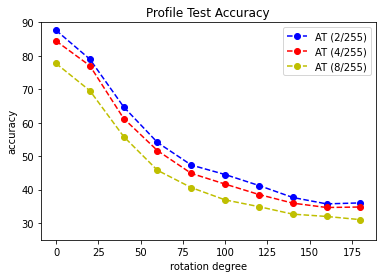

In [35]:
plt.plot(x, y, '--bo', label='AT (2/255)')
plt.plot(x, y2, '--ro', label='AT (4/255)')
plt.plot(x, y3, '--yo', label= 'AT (8/255)')
plt.title("Profile Test Accuracy")
plt.xlabel("rotation degree")
plt.ylabel("accuracy")
plt.ylim([25,90])
plt.legend()
plt.show()

In [37]:
import matplotlib.pyplot as plt

x = np.linspace(0,8/255,5)
y = []
y2 = []
y3 = []

for eps in x:
    val = test_robustness_pgd(model1, test_loader_cifar10, eps, 1/255, 10, printt=False)
    val2 = test_robustness_pgd(model2, test_loader_cifar10, eps, 1/255, 10, printt=False)
    val3 = test_robustness_pgd(model3, test_loader_cifar10, eps, 1/255, 10, printt=False)
    y.append(val)
    y2.append(val2)
    y3.append(val3)
    print("ciao")

ciao
ciao
ciao
ciao
ciao


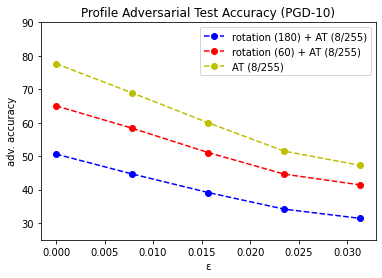

In [38]:
plt.plot(x, y,'--bo', label='rotation (180) + AT (8/255)')
plt.plot(x, y2,'--ro', label='rotation (60) + AT (8/255)')
plt.plot(x, y3,'--yo', label='AT (8/255)')
plt.title("Profile Adversarial Test Accuracy (PGD-10)")
plt.xlabel("\u03B5")
plt.ylim([25,90])
plt.ylabel("adv. accuracy")
plt.legend()
plt.show()

In [ ]:
import os

%cd /notebooks/
! ls
# Retrieve data directly from Stanford data source
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
  

# Tiny Imagenet

In [ ]:
# Unzip raw zip file
!unzip -qq 'tiny-imagenet-200.zip'


In [ ]:
# Define main data directory
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
# Create separate validation subfolders for the validation images based on
# their labels indicated in the val_annotations txt file
val_img_dir = os.path.join(VALID_DIR, 'images')

# Open and read val annotations text file
fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

# Create dictionary to store img filename (word 0) and corresponding
# label (word 1) for every line in the txt file (as key value pair)
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()

# Display first 10 entries of resulting val_img_dict dictionary
{k: val_img_dict[k] for k in list(val_img_dict)[:10]}

In [ ]:
# Create subfolders (if not present) for validation images based on label,
# and move images into the respective folders
for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

In [ ]:
import torch
import torchvision
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import transforms as T
from torchvision import models, datasets


transform = T.Compose([
                #T.RandomPerspective(distortion_scale=0.6, p=0.8), 
                T.RandomHorizontalFlip(),
                T.ToTensor(),  # Converting cropped images to tensors
])

transform2 = T.Compose([
                #T.CenterCrop(100), # Center crop image
                T.RandomHorizontalFlip(),
                T.ToTensor(),  # Converting cropped images to tensors
])

# Create DataLoaders for pre-trained models (normalized based on specific requirements)
dataset_tiny = trainset2 = torchvision.datasets.ImageFolder("/notebooks/tiny-imagenet-200/train/", transform=transform)
testset_tiny = torchvision.datasets.ImageFolder("/notebooks/tiny-imagenet-200/val/images", transform=transform2)

#create validation validation set 
train_set_tiny, val_set_tiny = random_split(dataset_tiny, [90000, 10000])


train_loader_tiny = torch.utils.data.DataLoader(train_set_tiny, batch_size=128, shuffle=True, num_workers=10)
test_loader_tiny = torch.utils.data.DataLoader(testset_tiny, batch_size=128, shuffle=True, num_workers=10)


Plot some exmaples of transformations

In [208]:
batch  = (next(iter(train_loader_imagenette)))[0]
print(len(batch))

10


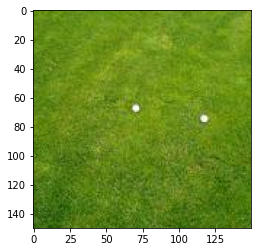

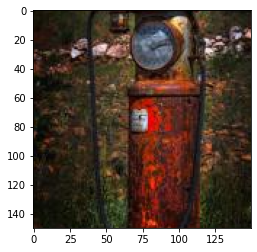

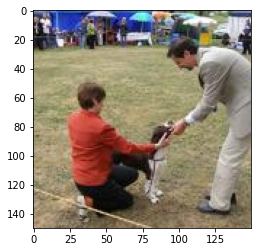

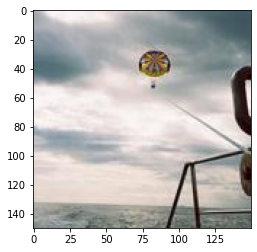

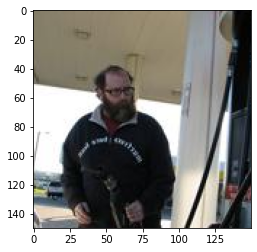

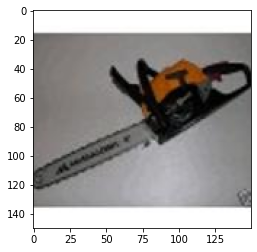

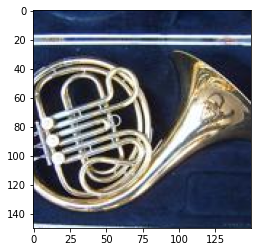

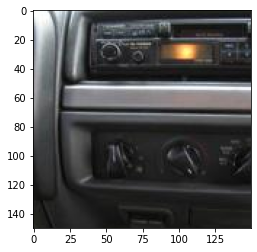

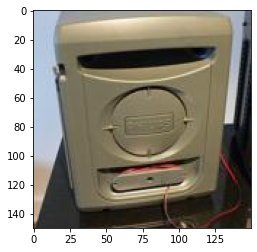

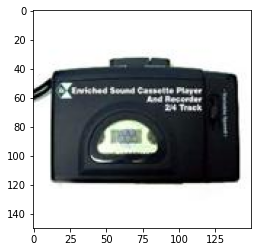

In [219]:
i=0
for (inputs) in batch:
    plt.figure()
    img = inputs.permute(1, 2, 0)
    #for p in inputs :
    plt.imshow(img)
    plt.show()

# Imagenette

In [242]:
import kornia

In [ ]:
! wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz

In [ ]:
# Unzip raw zip file
! mkdir imagenette
! tar -xzvf 'imagenette2-160.tgz' -C '/notebooks/imagenette'

In [5]:
means = (0.4914, 0.4822, 0.4465)

transform_train2 = transforms.Compose([
    
    #transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    #transforms.Normalize(means, (0.2023, 0.1994, 0.2010)),
])

transform_test2 = transforms.Compose([

    transforms.CenterCrop(150),
    transforms.ToTensor(),
    #transforms.Normalize(means, (0.2023, 0.1994, 0.2010)),
])


trainset_imagenette = torchvision.datasets.ImageFolder("/notebooks/imagenette/imagenette2-160/train", transform=transform_train2)
testset_imagenette = torchvision.datasets.ImageFolder("/notebooks/imagenette/imagenette2-160/val", transform=transform_test2)


train_set_imagenette, val_set_imagenette = torch.utils.data.random_split(trainset_imagenette, [8969,500])


#create the dataloaders
train_loader_imagenette = torch.utils.data.DataLoader(train_set_imagenette, batch_size=32, shuffle=True, num_workers=20)
val_loader_imagenette = torch.utils.data.DataLoader(val_set_imagenette, batch_size=64, shuffle=True, num_workers=20)
test_loader_imagenette = torch.utils.data.DataLoader(testset_imagenette, batch_size=64, shuffle=True, num_workers=20)

/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import kornia.augmentation as K

# PLOT SOME EXMAPLES OF TRANSFORMATIONs

# 1) perspective 2) Gaussian Noise

perspective = K.AugmentationSequential(K.RandomPerspective(distortion_scale=0.6, p=0.8))
gaussian_noise = K.AugmentationSequential(K.RandomGaussianNoise(mean=0, std=0.2, p=1))
motion_blur = K.AugmentationSequential(K.RandomMotionBlur(kernel_size=5, angle=(-180,180), p=1, direction=0.5))

batch = (next(iter(train_loader_imagenette)))[0]

batch_transformed = motion_blur(batch)

i=0
for (inputs) in batch_transformed:
    plt.figure()
    img = inputs.permute(1, 2, 0)
    #for p in inputs :
    plt.imshow(img)
    plt.show()

Text(0.5, 1.0, 'Moltion Blur (kernel size = 7)')

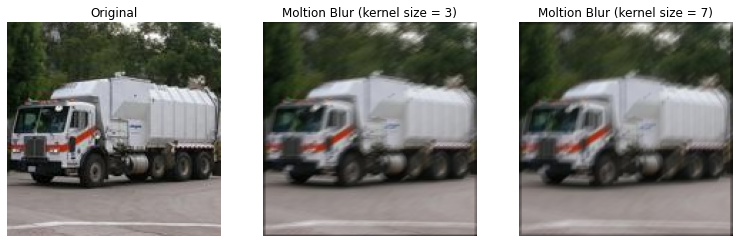

In [108]:
# setting values to rows and column variables
rows = 1
columns = 3
pic = 27

# create figure
fig = plt.figure(figsize=(13, 10))

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
inputs1 = batch[pic].permute(1,2,0)

# showing image
plt.imshow(inputs1)
plt.axis('off')
plt.title("Original")

# Adds a subplot at the 2st position
fig.add_subplot(rows, columns, 2)
inputs2 = batch_transformed[pic].permute(1,2,0)

# showing image
plt.imshow(inputs2)
plt.axis('off')
plt.title("Moltion Blur (kernel size = 3)")


# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
inputs3 = torch.reshape( K.RandomMotionBlur(kernel_size=7, angle=(-180,180), p=1, direction=0.5)(batch[pic]), (3,150,150)).permute(1,2,0)

# showing image
plt.imshow(inputs3)
plt.axis('off')
plt.title("Moltion Blur (kernel size = 7)")




In [107]:
print(perspective(batch[30]).shape)

torch.Size([1, 3, 150, 150])


In [ ]:
len(testset2)

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR

#model
norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

net1 = nn.Sequential(
    norm_layer,
    CNN()
).to(device)

net1 = net1.eval()
print(count_parameters(net1))


#hyper-params
epochs = 5
learning_rate = 0.001
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net1.parameters(), lr=learning_rate, weight_decay=5e-4)
loss_value = []

if torch.cuda.is_available():
    net1.cuda()


scheduler = ExponentialLR(optimizer, gamma=0.95)


for i in range(epochs):
    loss_avg = train(epoch=i, loader=train_loader, net=net1, optimizer=optimizer, loss_func=loss_func, log_freq=180)
    testing(net1, val_loader )
    scheduler.step()
    loss_value.append(loss_avg)

#plot training loss
y_ax = np.reshape(loss_value, (-1))
x = range(len(y_ax))
plt.plot(x,  y_ax)


#testing
testing(net1, test_loader)